In [1]:
import cv2
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import time
from tensorflow.keras import backend as K
from tensorflow.keras.utils import CustomObjectScope

In [2]:
H = 256
W = 256

In [3]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)


def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)


def mad(y_true, y_pred):
    return backend.mean(abs(y_pred - y_true))


def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + smooth) / (union + smooth)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

In [4]:
with CustomObjectScope({'dice_coef': dice_coef, 'dice_loss': dice_loss, 'mad':mad}):
    model = tf.keras.models.load_model("../../final-model/Set3_model.h5")

In [5]:
def get_prediction(path):
    imgBg = cv2.imread("../bg/1.jpg")
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    original_image = x
    
    h, w, _ = x.shape
    x = cv2.resize(x, (H, W))
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)
    x = np.expand_dims(x, axis=1)
    
    pred_mask = model.predict(x)[0]
    pred_mask = pred_mask[0]
    pred_mask = cv2.resize(pred_mask, (w, h))
    pred_mask = np.expand_dims(pred_mask, axis=-1)
    pred_mask = pred_mask > 0.5
    
    background_mask = np.abs(1- pred_mask)
    
    masked_image = original_image * pred_mask
    
    background_mask = np.concatenate([background_mask, background_mask, background_mask], axis=-1)
    
    imgBg = cv2.resize(imgBg, (w,h))
    
    background_mask = background_mask * imgBg
    
    masked_image = masked_image + background_mask
    masked_image = masked_image.astype(np.uint8)
    
    plot_images = [
        {'label':'Input', 'img':cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)}, 
        {'label':'Mask', 'img': pred_mask}, 
        {'label':'Output', 'img':cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)}
    ]
    
    return plot_images

In [6]:
def plots(plot_images):
    count = 0
    fig, axes = plt.subplots(1, 3, figsize=(20, 20))
    for idx, ax in enumerate(axes.flat):
        if plot_images[count]['label'] == 'Mask':
            ax.imshow(plot_images[count]['img'], cmap='gray')
        else:
            ax.imshow(plot_images[count]['img'])
        ax.set_title(plot_images[count]['label'], fontsize=30)
        ax.axis("off")
        count = count + 1
    plt.show()

1/1 [==============================] - 9s 9s/step


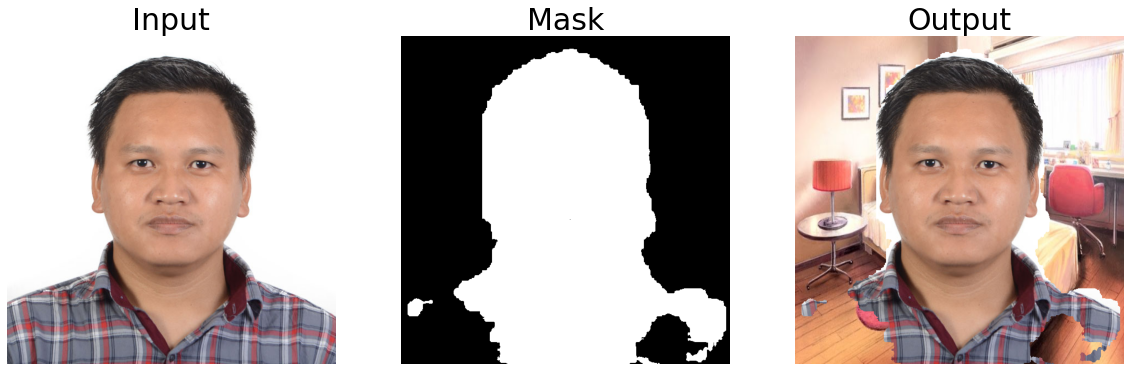

In [7]:
plot_images = get_prediction('../image/kiran.JPG')
plots(plot_images)

1/1 [==============================] - 0s 44ms/step


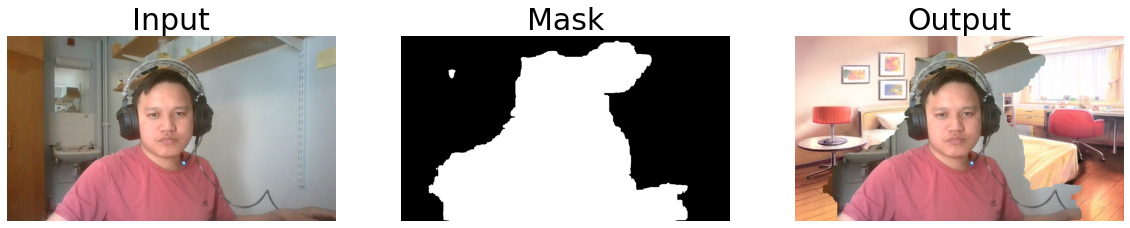

In [8]:
plot_images = get_prediction('../image/kiran_bg.jpg')
plots(plot_images)